# Importing the required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,cross_val_score,RandomizedSearchCV,TimeSeriesSplit,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.scorer import make_scorer
pd.set_option('mode.chained_assignment', None)

In [2]:
train = pd.read_csv(r"C:\Users\Tushar\Desktop\LTFS\train.csv",parse_dates=['application_date'])
test  = pd.read_csv(r"C:\Users\Tushar\Desktop\LTFS\test.csv",parse_dates=['application_date'])

In [3]:
print ("Shape of Training Data:{}".format(train.shape))
print ("Shape of Testing Data:{}".format(test.shape))

Shape of Training Data:(80402, 6)
Shape of Testing Data:(180, 3)


In [4]:
Submission_file = test[['id','application_date','segment']]
test.drop('id',axis=1,inplace=True)

In [5]:
df_train = train.copy()
df_test = test.copy()

In [6]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80402 entries, 0 to 80401
Data columns (total 6 columns):
application_date    80402 non-null datetime64[ns]
segment             80402 non-null int64
branch_id           66898 non-null float64
state               80402 non-null object
zone                66898 non-null object
case_count          80402 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 11.9 MB


# Training data starts from 1st of April 2017 and ends at 23rd of July 2019. 

In [7]:
train['application_date'].max(), train['application_date'].min()

(Timestamp('2019-07-23 00:00:00'), Timestamp('2017-04-01 00:00:00'))

# Segment1 have more values than Segment2

Text(0, 0.5, 'Count')

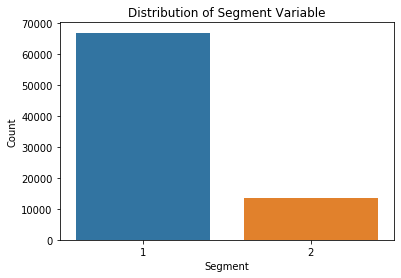

In [8]:
sns.countplot(train['segment'],order=train['segment'].value_counts().index)
plt.title("Distribution of Segment Variable")
plt.xlabel("Segment")
plt.ylabel("Count")

# All of the branch_id's have the same count i.e. 806 and this variable has 13504 missing values.

In [9]:
train['branch_id'].value_counts(dropna=False).head(10)

NaN       13504
 159.0      806
 17.0       806
 67.0       806
 269.0      806
 74.0       806
 268.0      806
 135.0      806
 62.0       806
 271.0      806
Name: branch_id, dtype: int64

# 83 unique branch_id's in total in train data

In [10]:
print ("Number of Unique Branch_Id's in Training Data:{}".format(train['branch_id'].nunique()))


Number of Unique Branch_Id's in Training Data:83


# Maharashtra has the largest count followed by other states, Delhi has the least count.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

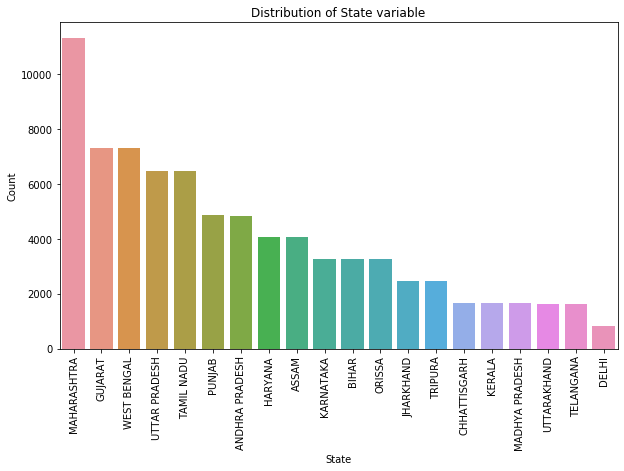

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(train['state'],order=train['state'].value_counts(dropna=False).index)
plt.title("Distribution of State variable")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=90)


# East has the highest count and Central has the least count.

Text(0, 0.5, 'Count')

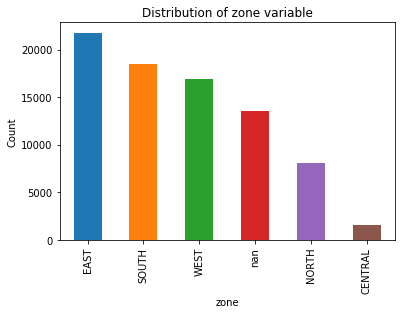

In [12]:
train['zone'].value_counts(dropna=False).plot(kind='bar')
plt.title("Distribution of zone variable")
plt.xlabel("zone")
plt.ylabel("Count")

In [13]:
train['case_count'].describe()

count    80402.000000
mean       185.481841
std        749.602925
min          0.000000
25%          0.000000
50%         18.000000
75%         60.000000
max      13787.000000
Name: case_count, dtype: float64

# There are lot of 0 values.

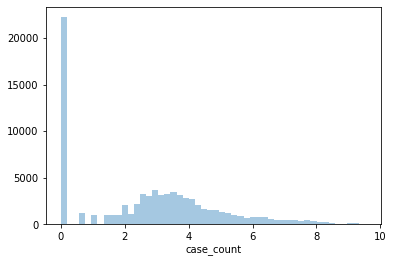

In [14]:
sns.distplot(np.log1p(train['case_count']),kde=False,bins=50)

In [15]:
train.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


# We can see that the Maximum value of case_count belongs to segment 2.\

In [16]:
train.groupby('segment')['case_count'].agg(['min','max','mean','median','std'])

,min,max,mean,median,std
segment,,,,,
1,0.0,1890.0,32.707106,14.0,61.591868
2,0.0,13787.0,942.318646,371.0,1624.339623


# Although the case count of Maharashtra is maximum, the sum of all case counts is maximum for Tamil Nadu.

In [17]:
train.groupby('state')['case_count'].agg(['count','min','max','mean','median','std','sum']).sort_values(by='count')

,count,min,max,mean,median,std,sum
state,,,,,,,
DELHI,806,0.0,1488.0,168.486352,136.0,148.757794,135800.0
UTTARAKHAND,1612,0.0,383.0,24.782258,20.0,27.525605,39949.0
TELANGANA,1612,0.0,1038.0,56.153226,0.0,88.913544,90519.0
KERALA,1650,0.0,3369.0,496.008485,39.5,722.016808,818414.0
CHHATTISGARH,1650,0.0,1111.0,181.298788,22.5,241.012685,299143.0
MADHYA PRADESH,1650,0.0,2350.0,348.672121,87.0,455.859267,575309.0
TRIPURA,2456,0.0,997.0,82.313111,32.0,142.665541,202161.0
JHARKHAND,2456,0.0,833.0,69.036645,20.0,137.794878,169554.0
BIHAR,3262,0.0,7691.0,419.025445,25.0,1111.541528,1366861.0


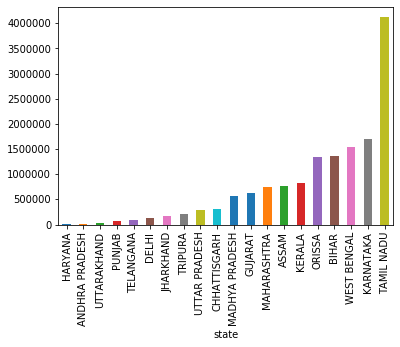

In [18]:
train.groupby('state')['case_count'].sum().sort_values().plot(kind='bar')

# Athough the case count of East zone is maximum, but the total case counts received in West zone is highest.

In [19]:
train.groupby('zone')['case_count'].agg(['count','min','max','mean','median','std','sum']).sort_values(by='count')

,count,min,max,mean,median,std,sum
zone,,,,,,,
CENTRAL,1612,0.0,609.0,23.082506,11.0,36.657118,37209.0
NORTH,8060,0.0,1488.0,27.383002,6.0,69.671582,220707.0
WEST,16926,0.0,1890.0,46.985053,23.0,77.373460,795269.0
SOUTH,18538,0.0,1143.0,26.973784,8.0,54.089844,500040.0
EAST,21762,0.0,1657.0,29.170802,16.0,48.989433,634815.0


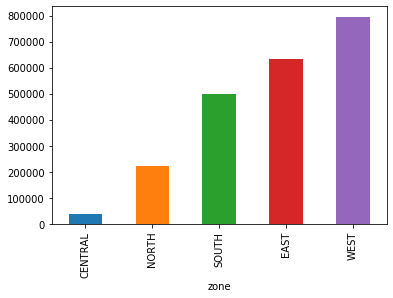

In [20]:
train.groupby('zone')['case_count'].sum().sort_values().plot(kind='bar')

# creating some more datetime based features

In [21]:
train['year'] = train.application_date.dt.year
train['month'] = train.application_date.dt.month
train['dayofweek'] = train.application_date.dt.dayofweek
train['day'] = train.application_date.dt.day
train['quarter'] = train.application_date.dt.quarter
train['is_month_start'] = train.application_date.dt.is_month_start
train['is_month_end'] = train.application_date.dt.is_month_end
train['is_quarter_start'] = train.application_date.dt.is_quarter_start
train['is_quarter_end'] = train.application_date.dt.is_quarter_end

In [22]:
test['year'] = test.application_date.dt.year
test['month'] = test.application_date.dt.month
test['dayofweek'] = test.application_date.dt.dayofweek
test['day'] = test.application_date.dt.day
test['quarter'] = test.application_date.dt.quarter
test['is_month_start'] = test.application_date.dt.is_month_start
test['is_month_end'] = test.application_date.dt.is_month_end
test['is_quarter_start'] = test.application_date.dt.is_quarter_start
test['is_quarter_end'] = test.application_date.dt.is_quarter_end

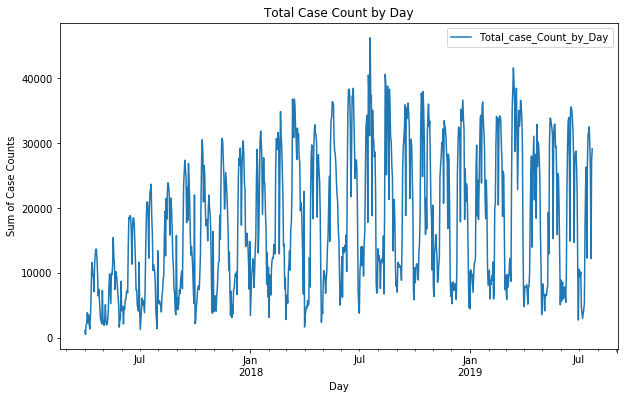

In [23]:
train.set_index('application_date').resample('D')['case_count'].sum().plot(kind='line',figsize=(10,6),label='Total_case_Count_by_Day')
plt.title("Total Case Count by Day")
plt.xlabel('Day')
plt.ylabel("Sum of Case Counts")
plt.legend(loc='best')
# We can see some kind of trend here, the sum total of case counts increases for sometime and then stays almost same. 
# We can also see a spike that is apart from the trend around July-Oct of 2018.

# We can see increasing and decreasing trends here

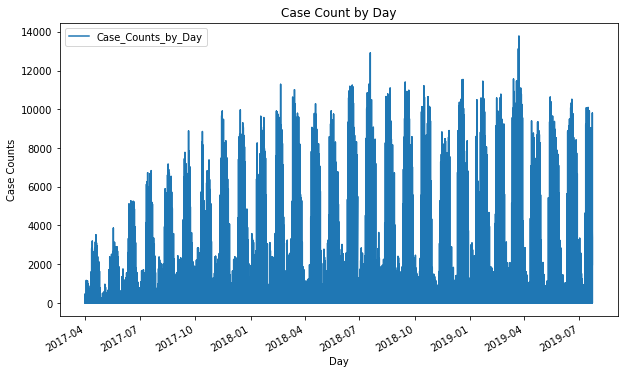

In [24]:
train.set_index('application_date')['case_count'].plot(kind='line',figsize=(10,6),label='Case_Counts_by_Day')
plt.title("Case Count by Day")
plt.xlabel('Day')
plt.ylabel("Case Counts")
plt.legend(loc='best')


# We can see increasing and decreasing trends here

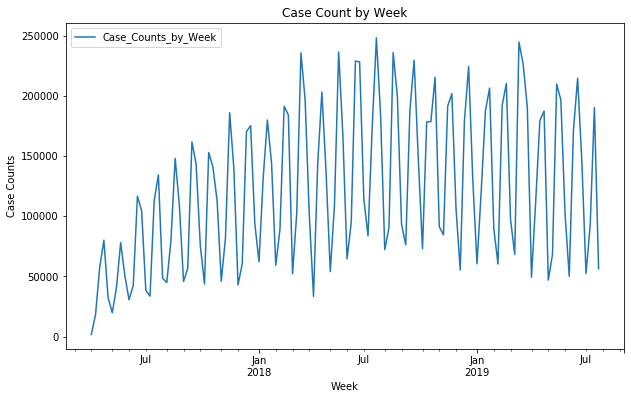

In [25]:
train.set_index('application_date').resample('W')['case_count'].sum().plot(kind='line',figsize=(10,6),label='Case_Counts_by_Week')
plt.title("Case Count by Week")
plt.xlabel('Week')
plt.ylabel("Case Counts")
plt.legend(loc='best')

# We can see a gradual increase for sometime and then series of increasing and decreasing trends followed by a dip at the end

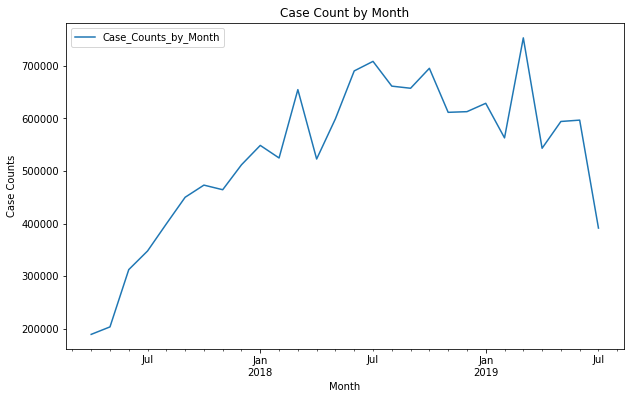

In [26]:
train.set_index('application_date').resample('M')['case_count'].sum().plot(kind='line',figsize=(10,6),label='Case_Counts_by_Month')
plt.title("Case Count by Month")
plt.xlabel('Month')
plt.ylabel("Case Counts")
plt.legend(loc='best')


# we can see a spike in the total case counts from 2017 to 2018

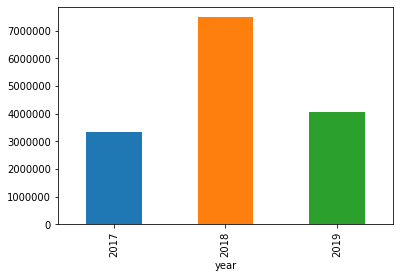

In [27]:
train.groupby('year')['case_count'].sum().sort_index().plot(kind='bar')

# case_count sum is maximum during the month of June followed by July,March and May which are close to each other. 

# It is minimum in the month of August.

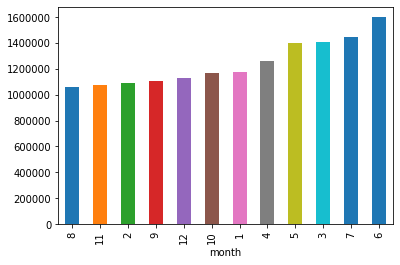

In [28]:
train.groupby('month')['case_count'].sum().sort_values().plot(kind='bar')

# Thursday has the highest occurence and Sunday has the least. 
# Wednesday has the highest sum total of case counts.

In [29]:
train.groupby('dayofweek')['case_count'].agg(['count','min','max','sum','mean']).sort_values(by='count')

,count,min,max,sum,mean
dayofweek,,,,,
6,11149,0.0,10250.0,1436647.0,128.858821
5,11398,0.0,13787.0,2135403.0,187.348921
2,11548,0.0,11160.0,2314316.0,200.408382
4,11548,0.0,13118.0,2262137.0,195.889938
0,11564,0.0,10805.0,2173422.0,187.947250
1,11564,0.0,11506.0,2280995.0,197.249654
3,11631,0.0,12908.0,2310191.0,198.623592


# Count is maximum during the 4th Quarter of 2017 and 3rd and 4th quarter of 2018.
# Sum is maximum during 3rd quarter of 2017.

In [30]:
train.groupby(['year','quarter'])['case_count'].agg(['count','min','max','sum','mean'])

count  min      max        sum        mean
year quarter                                            
2017 2         8428  0.0   5274.0   706232.0   83.795918
     3         8361  0.0   8884.0  1197941.0  143.277240
     4         9108  0.0   9963.0  1449814.0  159.180281
2018 1         8578  0.0  11288.0  1728408.0  201.493122
     2         9009  0.0  11241.0  1812629.0  201.202020
     3         9108  0.0  12908.0  2027253.0  222.579381
     4         9108  0.0  11536.0  1919816.0  210.783487
2019 1         8910  0.0  13787.0  1944961.0  218.289675
     2         9009  0.0  10629.0  1734401.0  192.518704
     3          783  0.0  10099.0   391656.0  500.199234

# Function to define MAPE

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_pred)) * 100

In [32]:
df_train.drop(['branch_id','state','zone'],axis=1,inplace=True)

In [33]:
df_train = df_train.groupby(['application_date','segment'],as_index=False)['case_count'].sum()
df_train.head()

,application_date,segment,case_count
0,2017-04-01,1,299.0
1,2017-04-01,2,897.0
2,2017-04-02,2,605.0
3,2017-04-03,1,42.0
4,2017-04-03,2,2016.0


In [34]:
holidays = ['2017-04-05','2017-04-09','2017-04-14','2017-05-01',
       '2017-05-10', '2017-06-25', '2017-06-26', '2017-08-07',
       '2017-08-14', '2017-08-15', '2017-08-25', '2017-09-02',
       '2017-09-04', '2017-09-30', '2017-10-01', '2017-10-02',
       '2017-10-19', '2017-12-01', '2017-12-25', '2018-01-01', 
       '2018-01-14', '2018-01-22', '2018-01-26',
       '2018-01-31', '2018-02-10', '2018-02-14', '2018-02-19',
       '2018-03-01', '2018-03-02', '2018-03-18', '2018-03-25',
       '2018-03-29', '2018-03-30', '2018-04-01', '2018-04-14',
       '2018-04-15', '2018-04-30', '2018-05-09', '2018-06-15',
       '2018-06-16', '2018-07-14', '2018-08-15', '2018-08-17',
       '2018-08-22', '2018-08-25', '2018-08-26', '2018-09-03',
       '2018-09-13', '2018-09-21', '2018-10-02', '2018-10-16',
       '2018-10-17', '2018-10-18', '2018-10-19', '2018-10-24',
       '2018-10-27', '2018-11-06', '2018-11-07', '2018-11-08',
       '2018-11-09', '2018-11-13', '2018-11-21', '2018-11-23',
       '2018-11-24', '2018-12-24', '2018-12-25', '2019-01-01',
       '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-26',
       '2019-02-10', '2019-02-19', '2019-03-01', '2019-03-04',
       '2019-03-20', '2019-03-21', '2019-04-06', '2019-04-13',
       '2019-04-14', '2019-04-15', '2019-04-17', '2019-04-19',
       '2019-04-21', '2019-05-09', '2019-05-18', '2019-05-31',
       '2019-06-05', '2019-07-04', '2019-08-12', '2019-08-15',
       '2019-08-17', '2019-08-24', '2019-09-02', '2019-09-10',
       '2019-09-11', '2019-10-02', '2019-10-05', '2019-10-06',
       '2019-10-07', '2019-10-08', '2019-10-13', '2019-10-17',
       '2019-10-27', '2019-10-28', '2019-10-29', '2019-11-02',
       '2019-11-10', '2019-11-12', '2019-11-24', '2019-12-24',
       '2019-12-25']
df_train['Holiday'] = (df_train.application_date.dt.date.astype("str").isin(holidays)).astype(int)
df_test['Holiday'] = (df_test.application_date.dt.date.astype("str").isin(holidays)).astype(int)

In [35]:
df_train.head()

,application_date,segment,case_count,Holiday
0,2017-04-01,1,299.0,0
1,2017-04-01,2,897.0,0
2,2017-04-02,2,605.0,0
3,2017-04-03,1,42.0,0
4,2017-04-03,2,2016.0,0


In [36]:
df_test.head()

,application_date,segment,Holiday
0,2019-07-06,1,0
1,2019-07-07,1,0
2,2019-07-08,1,0
3,2019-07-09,1,0
4,2019-07-10,1,0


In [37]:
df = df_train[df_train['segment'] == 1]
df.shape

(806, 4)

# defining a function to create a weekend indicator

In [38]:
def weekend_indicator(x):
    if (x>4 and x<=6):
        return True
    else:
        return False

# creating some more datetime features

In [39]:
df['year'] = df.application_date.dt.year
df['month'] = df.application_date.dt.month
df['dayofweek'] = df.application_date.dt.dayofweek
df['day'] = df.application_date.dt.day
df['quarter'] = df.application_date.dt.quarter
df['is_month_start'] = df.application_date.dt.is_month_start
df['is_month_end'] = df.application_date.dt.is_month_end
df['is_quarter_start'] = df.application_date.dt.is_quarter_start
df['is_quarter_end'] = df.application_date.dt.is_quarter_end
df['weekend'] = df['dayofweek'].apply(weekend_indicator)

In [40]:
cols = ['year','month','dayofweek','day','quarter']
for col in cols:
    df_train[col] = df[col].astype('category')

In [41]:
y = df['case_count']
X = df[[col for col in df.columns if col not in ['application_date','segment','case_count']]]

In [42]:

X_Train, X_Test, y_Train, y_Test = train_test_split(X,y,test_size=0.25,random_state=42)
print (X_Train.shape)
print (y_Train.shape)
print (X_Test.shape)
print (y_Test.shape)

(604, 11)
(604,)
(202, 11)
(202,)


In [43]:
model = RandomForestRegressor(n_jobs=1, random_state=42,n_estimators=1000,min_samples_leaf=2,max_depth=None)
model.fit(X_Train,y_Train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [44]:
y_pred = model.predict(X_Test)
mape_segment_1 = mean_absolute_percentage_error(y_Test,y_pred)
print (mape_segment_1)

28.764741601249792


In [45]:
ser = pd.Series(model.feature_importances_,X.columns).sort_values()
ser

is_quarter_start    0.000371
is_month_start      0.004411
is_quarter_end      0.006666
Holiday             0.013695
weekend             0.020430
quarter             0.041536
dayofweek           0.103284
year                0.148397
month               0.177944
is_month_end        0.217071
day                 0.266195
dtype: float64

In [46]:
df_test['year'] = df_test.application_date.dt.year
df_test['month'] = df_test.application_date.dt.month
df_test['dayofweek'] = df_test.application_date.dt.dayofweek
df_test['day'] = df_test.application_date.dt.day
df_test['quarter'] = df_test.application_date.dt.quarter
df_test['is_month_start'] = df_test.application_date.dt.is_month_start
df_test['is_month_end'] = df_test.application_date.dt.is_month_end
df_test['is_quarter_start'] = df_test.application_date.dt.is_quarter_start
df_test['is_quarter_end'] = df_test.application_date.dt.is_quarter_end
df_test['weekend'] = df_test['dayofweek'].apply(weekend_indicator)

for col in cols:
    df_train[col] = df[col].astype('category')

df_test_segment1 = df_test[df_test['segment'] == 1]
df_test_segment1.drop(['application_date','segment'],axis=1,inplace=True)

In [47]:
Submission_file.loc[Submission_file['segment'] == 1,'case_count'] = model.predict(df_test_segment1)

In [48]:
df = df_train[df_train['segment'] == 2]
df.shape

(844, 9)

In [49]:
# creating some more datetime features
df['year'] = df.application_date.dt.year
df['month'] = df.application_date.dt.month
df['dayofweek'] = df.application_date.dt.dayofweek
df['day'] = df.application_date.dt.day
df['quarter'] = df.application_date.dt.quarter
df['is_month_start'] = df.application_date.dt.is_month_start
df['is_month_end'] = df.application_date.dt.is_month_end
df['is_quarter_start'] = df.application_date.dt.is_quarter_start
df['is_quarter_end'] = df.application_date.dt.is_quarter_end
df['weekend'] = df['dayofweek'].apply(weekend_indicator)

In [50]:
cols = ['year','month','dayofweek','day','quarter']
for col in cols:
    df_train[col] = df[col].astype('category')

In [51]:
y = df['case_count']
X = df[[col for col in df.columns if col not in ['application_date','segment','case_count']]]

In [52]:
X_Train, X_Test, y_Train, y_Test = train_test_split(X,y,test_size=0.25,shuffle=False,random_state=42)
print (X_Train.shape)
print (y_Train.shape)
print (X_Test.shape)
print (y_Test.shape)

(633, 11)
(633,)
(211, 11)
(211,)


In [53]:
model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [54]:
y_pred = model.predict(X_Test)
mape_segment_2 = mean_absolute_percentage_error(y_Test,y_pred)
print (mape_segment_2)

9.122293215261353


In [55]:
ser = pd.Series(model.feature_importances_,X.columns).sort_values()
ser

is_quarter_end      0.000002
is_quarter_start    0.000191
is_month_start      0.000333
weekend             0.002155
is_month_end        0.004789
Holiday             0.005471
quarter             0.018427
dayofweek           0.058697
month               0.063907
year                0.154871
day                 0.691158
dtype: float64

In [56]:
final_mape = 0.5*mape_segment_1+0.5*mape_segment_2
print (final_mape)

18.943517408255573


In [57]:
df_test_segment2 = df_test[df_test['segment'] == 2]
df_test_segment2.drop(['application_date','segment'],axis=1,inplace=True)

In [58]:
Submission_file.loc[Submission_file['segment'] == 2,'case_count'] = model.predict(df_test_segment2)

In [59]:
Submission_file['case_count'] = Submission_file['case_count'].astype(int)

In [60]:
Submission_file.to_csv("submission_IIzFVsf_1.csv",index=None)

# Improving the model for better MAPE

In [61]:
my_scorer = make_scorer(mean_absolute_percentage_error,greater_is_better=True)

def final_mape (mape1,mape2):
    return 0.5*mape1+0.5*mape2

In [62]:
df_train = train.groupby(['application_date','segment'],as_index=False)['case_count'].sum()
df_train.shape

(1650, 3)

In [63]:
holidays = ['2017-04-05','2017-04-09','2017-04-14','2017-05-01',
       '2017-05-10', '2017-06-25', '2017-06-26', '2017-08-07',
       '2017-08-14', '2017-08-15', '2017-08-25', '2017-09-02',
       '2017-09-04', '2017-09-30', '2017-10-01', '2017-10-02',
       '2017-10-19', '2017-12-01', '2017-12-25', '2018-01-01', 
       '2018-01-14', '2018-01-22', '2018-01-26',
       '2018-01-31', '2018-02-10', '2018-02-14', '2018-02-19',
       '2018-03-01', '2018-03-02', '2018-03-18', '2018-03-25',
       '2018-03-29', '2018-03-30', '2018-04-01', '2018-04-14',
       '2018-04-15', '2018-04-30', '2018-05-09', '2018-06-15',
       '2018-06-16', '2018-07-14', '2018-08-15', '2018-08-17',
       '2018-08-22', '2018-08-25', '2018-08-26', '2018-09-03',
       '2018-09-13', '2018-09-21', '2018-10-02', '2018-10-16',
       '2018-10-17', '2018-10-18', '2018-10-19', '2018-10-24',
       '2018-10-27', '2018-11-06', '2018-11-07', '2018-11-08',
       '2018-11-09', '2018-11-13', '2018-11-21', '2018-11-23',
       '2018-11-24', '2018-12-24', '2018-12-25', '2019-01-01',
       '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-26',
       '2019-02-10', '2019-02-19', '2019-03-01', '2019-03-04',
       '2019-03-20', '2019-03-21', '2019-04-06', '2019-04-13',
       '2019-04-14', '2019-04-15', '2019-04-17', '2019-04-19',
       '2019-04-21', '2019-05-09', '2019-05-18', '2019-05-31',
       '2019-06-05', '2019-07-04', '2019-08-12', '2019-08-15',
       '2019-08-17', '2019-08-24', '2019-09-02', '2019-09-10',
       '2019-09-11', '2019-10-02', '2019-10-05', '2019-10-06',
       '2019-10-07', '2019-10-08', '2019-10-13', '2019-10-17',
       '2019-10-27', '2019-10-28', '2019-10-29', '2019-11-02',
       '2019-11-10', '2019-11-12', '2019-11-24', '2019-12-24',
       '2019-12-25']

In [64]:
df_train['year'] = df_train.application_date.dt.year
df_train['month'] = df_train.application_date.dt.month
df_train['dayofweek'] = df_train.application_date.dt.dayofweek
df_train['day'] = df_train.application_date.dt.day
df_train['quarter'] = df_train.application_date.dt.quarter
df_train['is_month_start'] = df_train.application_date.dt.is_month_start
df_train['is_month_end'] = df_train.application_date.dt.is_month_end
df_train['is_quarter_start'] = df_train.application_date.dt.is_quarter_start
df_train['is_quarter_end'] = df_train.application_date.dt.is_quarter_end
df_train['weekend'] = df_train.dayofweek.apply(weekend_indicator)

test['weekend'] = test.dayofweek.apply(weekend_indicator)

In [66]:
X = df_train[[col for col in df_train.columns if col not in ['application_date','case_count']]]
y = df_train['case_count']

In [67]:
cols = ['year','month','dayofweek','day','quarter']
for col in cols:
    df_train[col] = df_train[col].astype('category')
    test[col] = test[col].astype('category')

In [68]:

X_Train,X_Test,y_Train,y_Test = train_test_split(X,y,test_size=0.25,random_state=42)
print (X_Train.shape)
print (y_Train.shape)
print (X_Test.shape)
print (y_Test.shape)

(1237, 11)
(1237,)
(413, 11)
(413,)


In [69]:
test.drop('application_date',axis=1,inplace=True)

In [70]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
parameters = {"n_estimators":[500,1000,1500,2000],
              "max_depth":[5,7,9,11],
              "min_samples_leaf":[2,3,5,7],
              "min_samples_split":[2,5,7,9]}
search = RandomizedSearchCV(estimator=rf,param_distributions=parameters,cv=5,scoring=my_scorer,n_jobs=-1)
search.fit(X_Train,y_Train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [500, 1000, 1500, 2000], 'max_depth': [5, 7, 9, 11], 'min_samples_leaf': [2, 3, 5, 7], 'min_samples_split': [2, 5, 7, 9]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(mean_absolute_percentage_error), verbose=0)

In [71]:
y_pred = search.best_estimator_.predict(X_Test)
print (mean_absolute_percentage_error(y_Test,y_pred))

29.955158482000073


In [72]:
search.best_estimator_,search.best_params_,search.best_score_

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
 {'n_estimators': 2000,
  'min_samples_split': 5,
  'min_samples_leaf': 5,
  'max_depth': 5},
 27.112202853454885)

In [74]:
Submission_file['case_count'] = search.best_estimator_.predict(test)

In [75]:
Submission_file['case_count'] = Submission_file['case_count'].astype(int)

In [76]:
Submission_file.to_csv("submission_IIzFVsf_2.csv",index=None)